Eighth exercice: MR image reconstruction from Cartesian data
==============================================

In this tutorial we will reconstruct a 2D MR image from multicoil Cartesian under-sampled kspace measurements.

We use the toy datasets available in pysap, more specifically a 2D brain slice and under-sampled Cartesian acquisition over 32 channels.
We compare zero-order image reconstruction with Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation.Sparsity will be promoted in the wavelet domain, using either Symmlet-8 (analysis and synthesis) or undecimated bi-orthogonal wavelets (analysis only). The sensitivity maps $(S_\ell)_\ell$ are automically calibrated from the central portion of k-space (e.g. 5%) for all channels $\ell=1, \ldots, L$.

We remind that the synthesis formulation of the CS-PMRI problem reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \sum_{\ell=1}^L\|y_\ell - \Omega F S_\ell \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \sum_{\ell=1}^L \|y_\ell - \Omega F S_\ell x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [16]:
from mri.operators import FFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SelfCalibrationReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

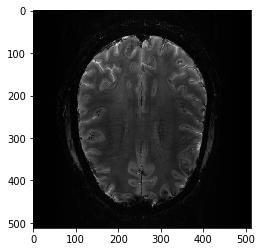

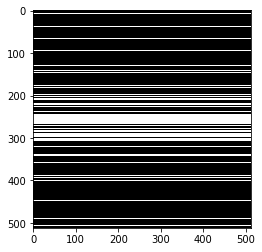

In [2]:
%matplotlib inline

cartesian_ref_image = get_sample_data('2d-pmri')
image = pysap.Image(data=np.sqrt(np.sum(cartesian_ref_image.data**2, axis=0)))
# Obtain MRI non-cartesian mask
mask = get_sample_data("cartesian-mri-mask")
kspace_loc = convert_mask_to_locations(mask.data)
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()


Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [4]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(samples=kspace_loc, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

Zero order solution

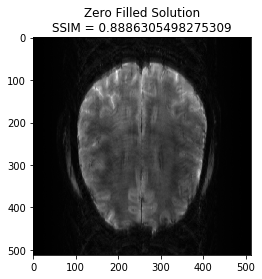

In [5]:
zero_filled = fourier_op.adj_op(kspace_obs)
image_rec0 = pysap.Image(data=np.sqrt(np.sum(np.abs(zero_filled)**2, axis=0)))
# image_rec0.show()
base_ssim = ssim(image_rec0, image)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()

Synthesis formulation: FISTA vs POGM optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [6]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
#linear_op = WaveletN(wavelet_name="sym8", nb_scales=4, padding_mode="periodization")

regularizer_op = SparseThreshold(Identity(), 15e-9, thresh_type="soft")
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    kspace_portion=0.01,
    verbose=1,
)

In [8]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = pysap.Image(data=x_final)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

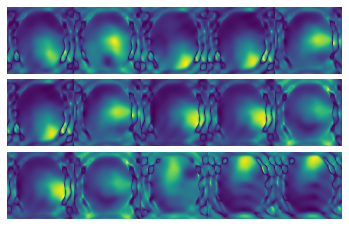

In [12]:
h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(reconstructor.extra_grad_args['Smaps'][3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

## POGM optimization 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


Lipschitz constant is 1.0984994731260065
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.0984994731260065
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7ff63871bb90> - 4
 - max iterations:  100
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - final iteration number:  100
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  55.484521421953104  seconds
----------------------------------------


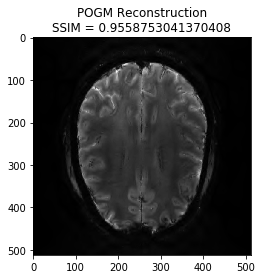

In [13]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=100,
)
image_rec = pysap.Image(data=x_final)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('POGM Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

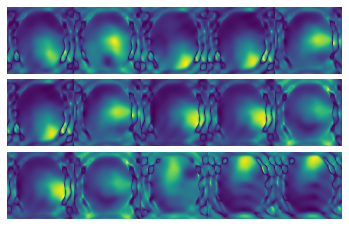

In [14]:
h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(reconstructor.extra_grad_args['Smaps'][3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [18]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
#linear_op = WaveletUD2(
#    wavelet_id=24,
#    nb_scale=4,
#)

In [20]:
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    kspace_portion=0.01,
    verbose=1,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


Lipschitz constant is 1.0992819789943202
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.0992819789943202
 - tau:  0.9527066877905468
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7ff638561ed0> - 4
 - max iterations:  100
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  100
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  50.16925545001868  seconds
----------------------------------------


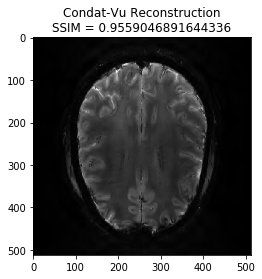

In [22]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=100,
)

image_rec = pysap.Image(data=x_final)
recon_ssim = ssim(image_rec, image)

plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()